In [ ]:
# -*- coding: utf-8 -*-

"""Cross correlation between each clusters' timeseries with NINO index."""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def full_ccf(x, y):
    """
    Computes cross-correlation between two series x and y.
    Returns the full correlation and the lags.
    """
    x = np.asarray(x, dtype=float).ravel()
    y = np.asarray(y, dtype=float).ravel()

    # Mean removal (Anomaly)
    x = x - x.mean()
    y = y - y.mean()

    # Correlation
    corr = np.correlate(x, y, mode="full")

    # Normalization (Pearson correlation coeff scale -1 to 1)
    # Note: This normalization assumes stationarity within the window
    corr /= np.std(x) * np.std(y) * len(x)

    # Generate lags
    lags = np.arange(-len(x) + 1, len(x))

    return lags, corr



In [21]:
# --- Main Execution ---

# 1. Load NINO34 Index
nino_index = pd.read_fwf(
    "../Data/oni.data",
    widths=[5] + [7]*12,
    names=['Year'] + list(range(1, 13)), 
    skiprows=1,
    skipfooter=9,
)
# 1. Wide to Long 변환 (Melting)
# id_vars='Year': 연도는 유지
# var_name='Month': 1~12 컬럼 명을 'Month'라는 새로운 컬럼의 값으로 변환
# value_name='ONI': 값들을 'ONI'라는 새로운 컬럼으로 저장
nino_long = nino_index.melt(id_vars='Year', var_name='Month', value_name='ONI')

# 2. 날짜(Datetime) 인덱스 생성
# 연도와 월을 문자열로 합쳐 YYYY-MM-01 형식으로 만든 후 datetime 변환
nino_long['Date'] = pd.to_datetime(
    nino_long['Year'].astype(str) + '-' + nino_long['Month'].astype(str) + '-01'
)

# 3. 정렬 및 정리
# 날짜순 정렬 후 Index로 설정
nino_long = nino_long.set_index('Date').sort_index()

# 불필요한 컬럼 제거 (순수 시계열만 남김)
nino_series = nino_long[['ONI']]

# 결과 확인
print(nino_series.head())
print(nino_series.tail())


             ONI
Date            
1950-01-01 -1.53
1950-02-01 -1.34
1950-03-01 -1.16
1950-04-01 -1.18
1950-05-01 -1.07
             ONI
Date            
2024-08-01 -0.11
2024-09-01 -0.21
2024-10-01 -0.26
2024-11-01 -0.37
2024-12-01 -0.53


In [27]:
# 1. 6, 7, 8월 데이터만 필터링
jja_mask = nino_series.index.month.isin([6, 7, 8])
nino_jja_series = nino_series[jja_mask]

# 2. 연도별로 다시 리샘플링하여 평균 계산
nino_jja_mean = nino_jja_series.resample('YE').mean()

# 컬럼명 변경 (명확성을 위해)
nino_jja_mean.columns = ['ONI_JJA']

print(nino_jja_mean.head())

             ONI_JJA
Date                
1950-12-31 -0.603333
1951-12-31  0.723333
1952-12-31 -0.026667
1953-12-31  0.750000
1954-12-31 -0.660000


In [28]:
# 2. Load Cluster Counts
norm_counts = pd.read_csv(
    "../Data/u850_cluster_counts.csv", usecols=range(1, 10)
)
X = norm_counts.to_numpy()
y = nino_jja_mean
# 데이터 길이 일치 확인
min_len = min(len(y), len(X))
y = y[:min_len]
X = X[:min_len, :]

n_clusters = X.shape[1]

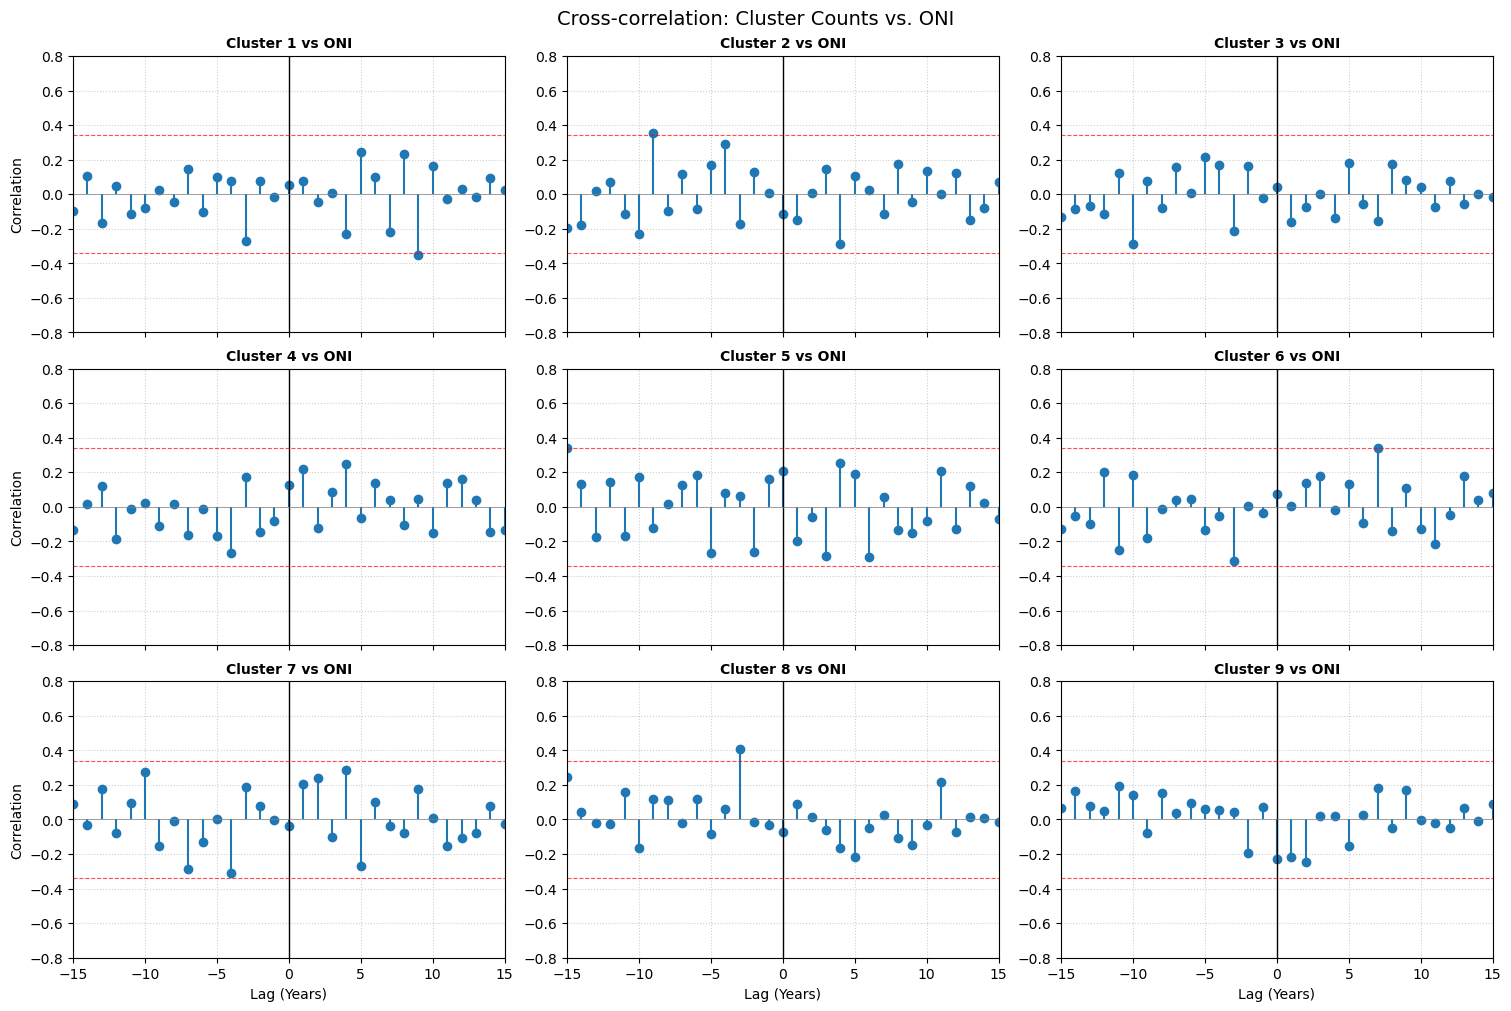

In [29]:
# 3. Plotting
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, constrained_layout=True)

# 95% Confidence Interval Threshold
conf_interval = 1.96 / np.sqrt(len(y))

# --- Lag 제한 설정 (15년) ---
max_lag = 15

for i, ax in enumerate(axes.flat):
    if i < n_clusters:
        lags, corr = full_ccf(X[:, i], y)

        # Stem plot
        markerline, stemlines, baseline = ax.stem(lags, corr, basefmt=" ")
        plt.setp(stemlines, "linewidth", 1.5)

        # Style improvements
        ax.axvline(0, color="black", linestyle="-", linewidth=1)  # Zero lag line
        ax.axhline(0, color="gray", linewidth=0.5)

        # Significance lines (Red dashed)
        ax.axhline(conf_interval, color="red", linestyle="--", linewidth=0.8, alpha=0.7)
        ax.axhline(
            -conf_interval, color="red", linestyle="--", linewidth=0.8, alpha=0.7
        )

        ax.set_ylim(-0.8, 0.8)

        # --- X축 범위 제한 (-15 ~ +15) ---
        ax.set_xlim(-max_lag, max_lag)

        ax.set_title(f"Cluster {i + 1} vs ONI", fontsize=10, fontweight="bold")
        ax.grid(True, linestyle=":", alpha=0.6)

        if i % 3 == 0:
            ax.set_ylabel("Correlation")
        if i >= 6:
            ax.set_xlabel("Lag (Years)")

fig.suptitle("Cross-correlation: Cluster Counts vs. ONI", fontsize=14)
plt.savefig("../Results/cross-corr_oni.png", dpi=300)
plt.show()

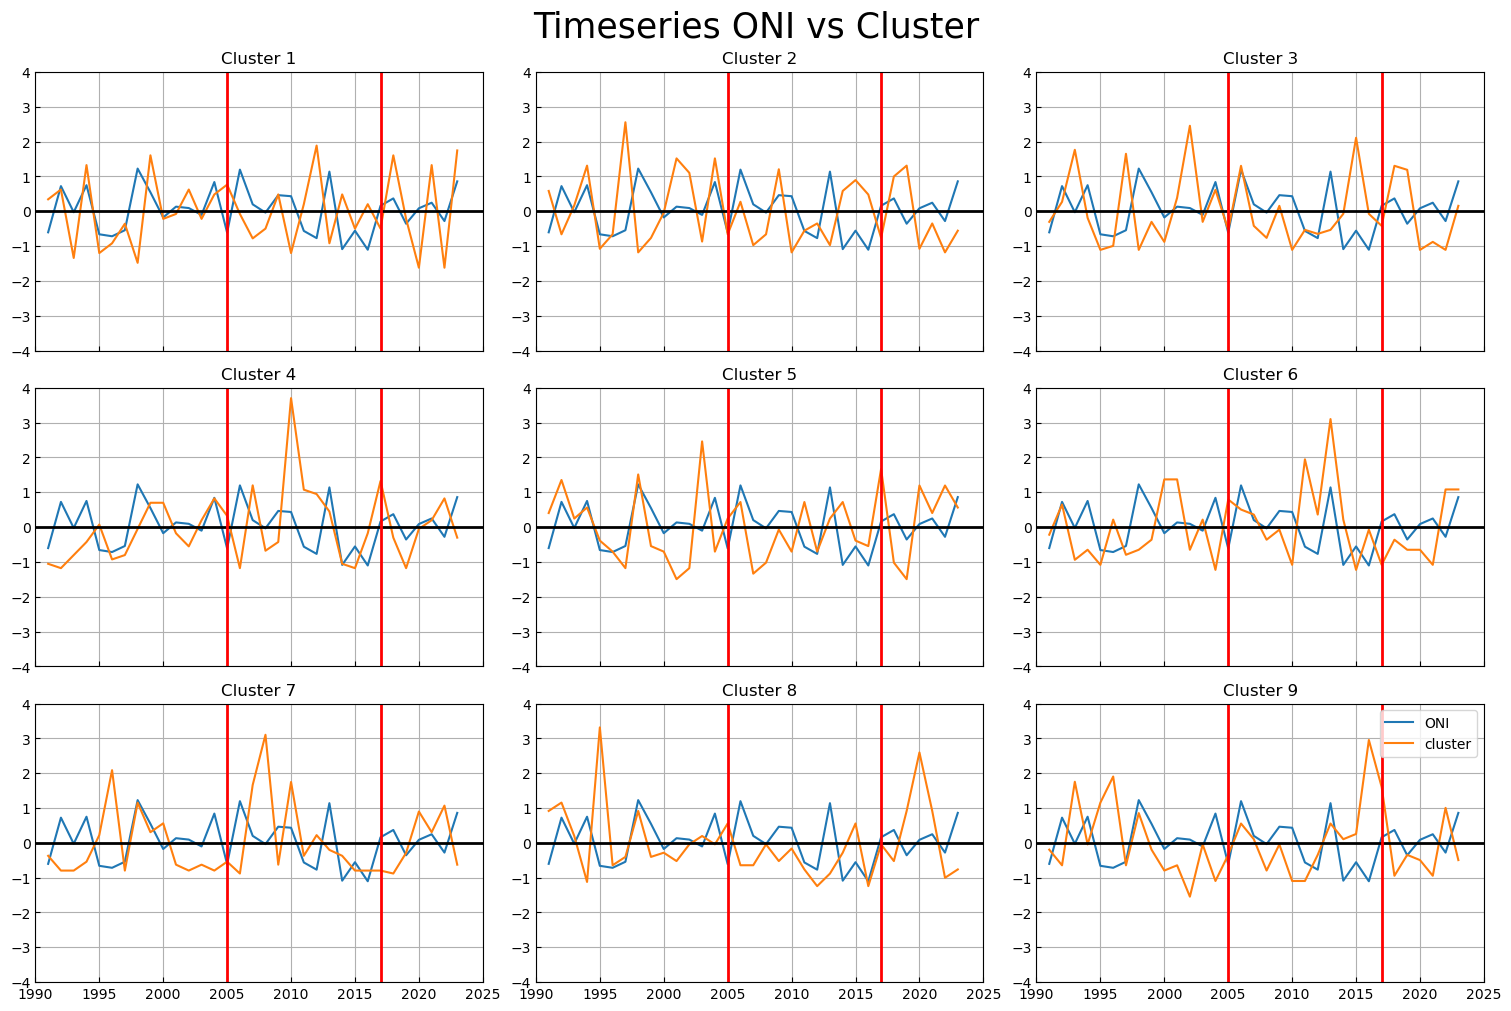

In [30]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, constrained_layout=True)
for i, ax in enumerate(axes.flat):
    xn = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])
    ax.plot(np.linspace(1991, 2023, 33), y, label="ONI")
    ax.plot(np.linspace(1991, 2023, 33), xn, label="cluster")
    ax.axhline(0, lw=2, color="k")
    ax.axvline(2005, lw=2, color="r")
    ax.axvline(2017, lw=2, color="r")
    ax.tick_params(axis="both", tickdir="in")
    ax.set_xlim(1990, 2025)
    ax.set_ylim(-4, 4)
    ax.grid(True)
    ax.set_title(f"Cluster {i + 1}")
    if i == 8:
        ax.legend(loc="upper right")

fig.suptitle("Timeseries ONI vs Cluster", fontsize=25)
plt.savefig("../Results/ts_vs_oni.png", dpi=300)
plt.show()